In [1]:
import matplotlib.pyplot as plt
textwidth = 15
figheight = 0.25*textwidth
plt.rcParams["figure.figsize"] = (0.66*textwidth,figheight)
plt.rcParams['text.latex.unicode']=True
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('grid', linestyle="--")
plt.rc('grid', alpha="0.5")
plt.rc('axes', grid=True)

import numpy as np
import re

!mkdir fig

# Benchmarks structure de données
## Conditions 

### Machine de test

https://groupes.renater.fr/wiki/poincare/public/description_de_poincare

### Benchmark

le benchmark ** bench_mesh ** est executé en faisant varier :
* nb_proc : nombre de processus MPI
* nb_threads : pour les executions avec 1 processus MPI, on utilise 1, 8, ou 16 coeurs, lorsqu'il y a plusieurs processus MPI, on se contente de 8 coeurs (1 socket)
* Taille des données : on fait varier le nombre d'éléments pour 1e5, les données tiennent en cache, mais pas pour 1e6 elements 

On y mesure les performances de différents algorithmes de parcours:
* Stream : Parcours de référence utilisant des std::vectors simples
* Nodes : Parcours des noeuds en utilisant container::MeshHelper::foreach_nodes
* Nodes with Segs : Parcours des noeuds avec segment connectés en utilisant container::MeshHelper::foreach_nodesWithSegs
* Segs with Nodes : Parcours des segments avec noeuds connectés en utilisant container::MeshHelper::foreach_segsWithNodes

'Nodes with Segs' et 'Segs with Nodes' doivent utiliser des données distantes en MPI. Deux variantes existent pour les benchmarks MPI :
* Avec communications MPI : toutes les données concernant les objets distants sont échangées avant chaque parcours.
* Sans communications MPI : On suppose que les données concernant les objets distants sont à jours dans le cache, et l'échange MPI n'est pas nécéssaire

Le benchmark mesure le temps d'execution de 4 parcours. ** bench_mesh ** crée un ficher avec pour nom out_p<nb_proc>_r<rang>_t<nb_threads>_s<size> :

In [2]:
!cat data/out_p1_r0_t8_s1e+05

#Clock percision is 1ns
#Density is 5e+14 m/m^3, segment length is 50.03 A
#size = 100000 (1.0e+05) , ITER = 100
#omp_max_threads = 8
#Times in ns for fastest iteration
         Compute (MFlops):        1.2        2.4        4.8        9.6       19.2       38.4       76.8      153.6      307.2      614.4
      load/store (MBytes):        7.2        7.2        7.2        7.2        7.2        7.2        7.2        7.2        7.2        7.2
                   Stream:       36.7       38.0       42.4      306.1      572.2     1142.7     2308.0     5000.4    11080.8    21485.3
# Mesh construct time = 76.4 ms
                    Nodes:       63.4       91.0      317.3      299.5      555.8     1146.9     2299.0     5003.9    11114.5    21517.4
          Segs with Nodes:      107.4      135.3      260.5      481.1      736.3     1328.8     2527.6     5371.6    11252.4    21662.5
  Segs with Nodes (nompi):       96.8      124.8      249.0      468.6      726.2     1315.8     2515.0     5356.2

## Extraire les données

In [3]:
!grep -r ':' data/out_* > data/mesh_iterate_data.txt

res_matrix={}
flops_count={}
loadstore_size={}

for line in open("data/mesh_iterate_data.txt"):
    nb_proc,rank,threads,size,name,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10 = re.match(".*out_p(\d*)_r(\d*)_t(\d*)_s(\d*e\+\d*):\s*([^:]*):\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)", line).groups()
    ts = np.array([t1,t2,t3,t4,t5,t6,t7,t8,t9,t10],dtype='f')
    rank=int(rank)
    nb_proc=int(nb_proc)
    threads=int(threads)
    if name == 'Compute (MFlops)' :
        flops_count[size,nb_proc] = ts
    elif name == 'load/store (MBytes)' :
        loadstore_size[size,nb_proc] = ts
    else :
        res_matrix[nb_proc,rank,threads,size,name] = ts

list_nb_procs = sorted([a for a in set([ p for (p,r,t,s,n) in  res_matrix.keys() ])])
list_threads = sorted([a for a in set([ t for (p,r,t,s,n) in  res_matrix.keys() ])])
list_sizes = sorted([a for a in set([ s for (p,r,t,s,n) in  res_matrix.keys() ])])
list_names = [a for a in set([ n for (p,r,t,s,n) in  res_matrix.keys() ])]

label_names = {}
label_names['Stream'] = "Tableaux simples"
label_names['Nodes'] = "Nœuds"
label_names['Segs with Nodes'] = "Segments + Nœuds connectés"
label_names['Nodes with Segs'] = "Nœuds + Segments connectés"
label_names['Segs with Nodes (nompi)'] = "Segments + Nœuds connectés (sans MPI)"
label_names['Nodes with Segs (nompi)'] = "Nœuds + Segments connectés (sans MPI)"

## Benchmarks OpenMP

### Mesures Roofline

Les bandes passantes RAM sont mesurées avec le benchmark STREAM (triad) sur 1, 8, et 16 coeurs
* 1 coeur : 14.0Go/s
* 1 noeud NUMA (8 coeurs): 29.9Go/s
* 1 noeud complet (16 coeurs) : 59,5Go/s

Les puissance de calcul crète (GFlops/s) est la puissance théorique du processeur :
* 2.6 GHz \* 2 ALU * 4 double/opération = 20.8 GFlops/s/coeur
* 5.2 GFlops/s/coeur sans vectorisation

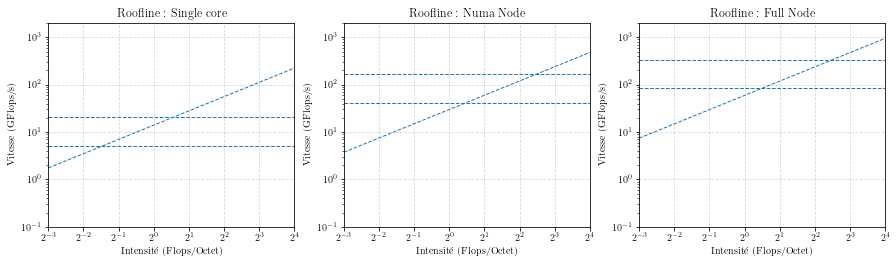

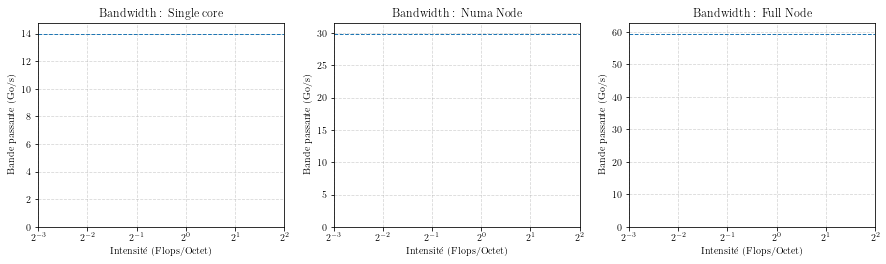

In [4]:
nb_threads=list_threads

titles_threads = {nb_threads[0]:"Single core", nb_threads[1]:"Numa Node", nb_threads[2]:"Full Node"}
bandwidth = { nb_threads[0]:14.0, nb_threads[1]:29.9, nb_threads[2]:59.5}
peak = { nb_threads[0]:20.8, nb_threads[1]:166.4, nb_threads[2]:332.8}


def plot_roofline(threads):
    line = plt.axhline(y=peak[threads], linestyle='dashed', linewidth=1)
    Is = np.array([1./8,16])
    plt.axhline(y=peak[threads]/4, linestyle='dashed', linewidth=1, color=line.get_color())
    plt.plot( Is, Is*bandwidth[threads], linestyle='dashed', linewidth=1, color=line.get_color() )
    plt.xlabel( "Intensité (Flops/Octet)" )
    plt.ylabel( "Vitesse (GFlops/s)" )
    plt.xscale('log',basex=2)
    plt.yscale('log')
    plt.ylim([0.1,2000])
    plt.xlim(Is)

i=1
plt.figure(figsize=(textwidth,figheight))
for threads in titles_threads.keys():
    plt.subplot(1, 3, i).title.set_text("Roofline : " + titles_threads[threads])
    plot_roofline(threads)
    i=i+1
plt.savefig("fig/bench_mesh_roofline.pdf", transparent=True, bbox_inches='tight')
plt.show()

def plot_bandwidth(threads):
    plt.axhline(y=bandwidth[threads], linestyle='dashed', linewidth=1)
    plt.xlabel( "Intensité (Flops/Octet)" )
    plt.ylabel( "Bande passante (Go/s)" )
    plt.xscale('log',basex=2)
    #plt.yscale('log')
    plt.ylim(0)
    Is = np.array([1./8,4])
    plt.xlim(Is)
i=1
plt.figure(figsize=(textwidth,figheight))
for threads in titles_threads.keys():
    plt.subplot(1, 3, i).title.set_text("Bandwidth : " + titles_threads[threads])
    plot_bandwidth(threads)
    i=i+1

plt.show()


### Mesures structure de données

#### Roofline

Le roofline model donne un apercu de l'efficacité du parcours des stuctures de données en affichant la performance maximale atteignable et en placant la performance mesurée sur un graphique.

Les performances sont calculées sur la base des Flops **utiles** executées lors d'un parcours.

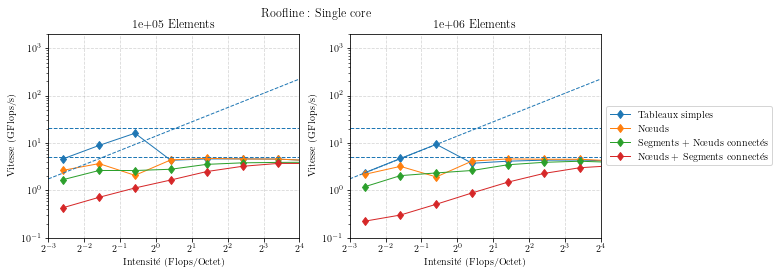

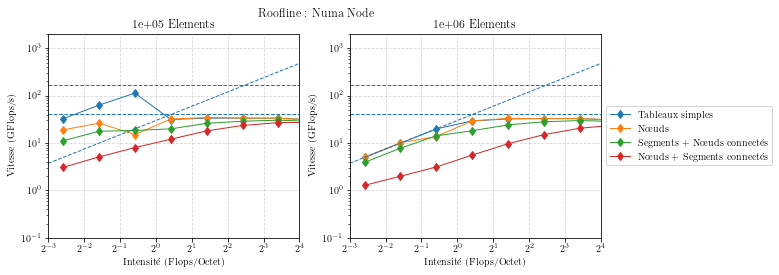

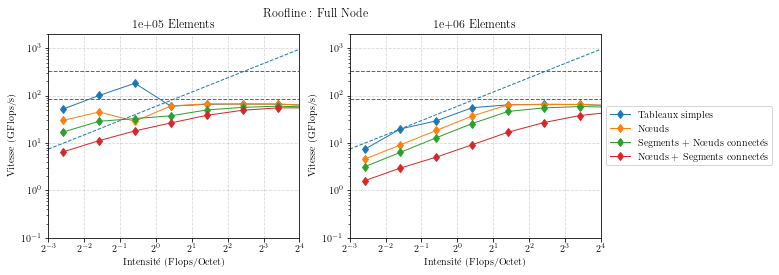

In [5]:
nb_proc=1
rank=0

#list_sizes = ['1e+05', '1e+06']
list_names_nompi = ["Stream", "Nodes", "Segs with Nodes", "Nodes with Segs"]

def plot_roofline_perf( threads, size ):
    for name in list_names_nompi:
        intensities = flops_count[size,nb_proc]/loadstore_size[size,nb_proc]
        Gflopss = (flops_count[size,nb_proc]/res_matrix[nb_proc,rank,threads,size,name])*1000
        plt.plot( intensities, Gflopss, 'd-', label=label_names[name], linewidth=1 )
    plot_roofline(threads) 
    
for threads in list_threads:
    i=1
    plt.suptitle("Roofline : " + titles_threads[threads])
    for size in list_sizes:        
        subplt = plt.subplot(1, 2, i).title.set_text(size+" Elements ")
        plot_roofline_perf(threads, size) 
        i=i+1
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    plt.show()

#### Bande passante

Les graphiques de bande passante présentent les mêmes données, mais permettent de mieux voir les valeurs mesurées dans la partie memory-bound du roofline model

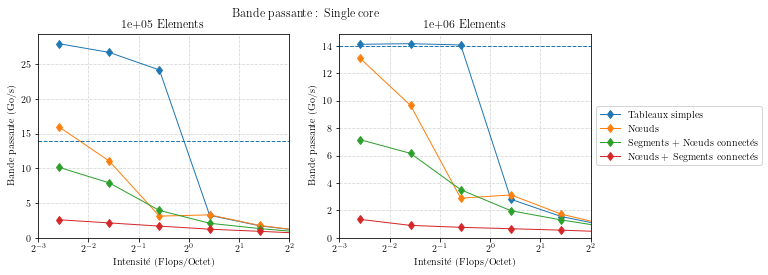

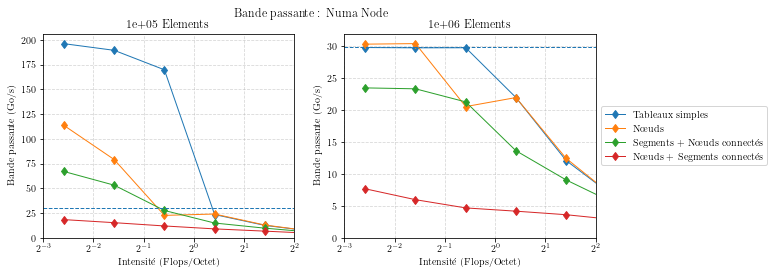

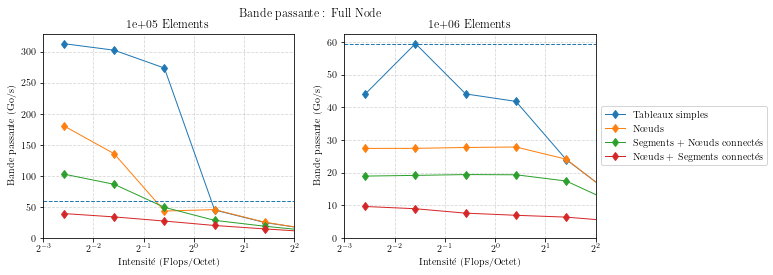

In [6]:
nb_proc=1

def plot_bandwidth_perf( threads, size ) :
    for name in list_names_nompi:
        intensities = flops_count[size,nb_proc]/loadstore_size[size,nb_proc]
        GBps = (loadstore_size[size,nb_proc]/res_matrix[nb_proc,rank,threads,size,name])*1000
        plt.plot( intensities, GBps, 'd-', label=label_names[name], linewidth=1 )
    plot_bandwidth(threads)

for threads in list_threads:
    i=1
    plt.suptitle("Bande passante : " + titles_threads[threads])
    for size in list_sizes:        
        plt.subplot(1, 2, i).title.set_text(size+" Elements ")
        plot_bandwidth_perf( threads, size )     
        i=i+1
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    plt.show()

#### Comportement général

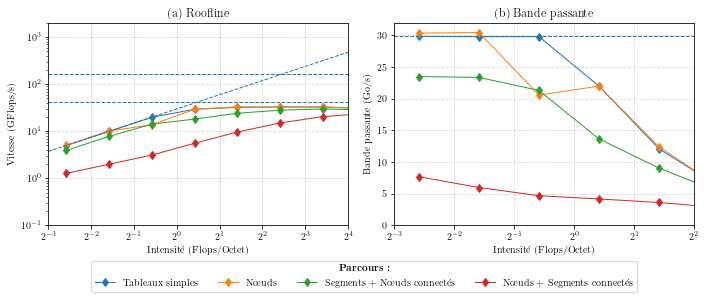

In [7]:
plt.figure(figsize=(0.66*textwidth, figheight))

plt.subplot(121).title.set_text("(a) Roofline")
plot_roofline_perf(8,'1e+06')

plt.subplot(122).title.set_text("(b) Bande passante")
plot_bandwidth_perf(8,'1e+06')

plt.tight_layout()
plt.legend(ncol=4, loc='upper center',  title="{\\bf Parcours :}", bbox_to_anchor=(-0.1, -0.15))

plt.savefig("fig/bench_mesh_omp.pdf", transparent=True, bbox_inches='tight')
plt.show()

 *Figure* - Performance des parcours de la structure de données pour un volume de données dépassant la capacité du cache L3 ($10^6$ éléments) sur un noeud NUMA (8 threads) 

Les parcours de la structure de données sur un noeud NUMA, et pour des données plus grosses que le cache utilisent bien les capacités de la machine. 
* Le parcours des noeuds a une performance proche du parcours de référence 'Stream' sur des tableaux simples.
* Le parcours des segments avec les noeuds connectés est un peu moins rapide à cause des accès irréguliers.
* Le parcours des noeuds avec segments connectés est moins performant car il est impossible de connaitre à l'avance combien de segments sont connectés à un noeud.

Le choix du volume de données et du multithreading est justifié dans les sections suivantes.

#### Comportement en fonction du nombre de thread

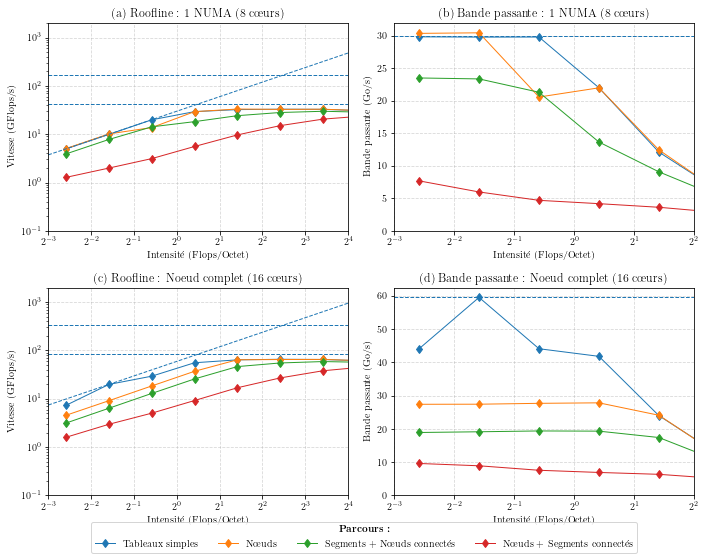

In [8]:
plt.figure(figsize=(0.66*textwidth, 2*figheight))

plt.subplot(221).title.set_text("(a) Roofline : 1 NUMA (8 cœurs)")
plot_roofline_perf(8,'1e+06')

plt.subplot(222).title.set_text("(b) Bande passante : 1 NUMA (8 cœurs)")
plot_bandwidth_perf(8,'1e+06')

plt.subplot(223).title.set_text("(c) Roofline : Noeud complet (16 cœurs)")
plot_roofline_perf(16,'1e+06')

plt.subplot(224).title.set_text("(d) Bande passante : Noeud complet (16 cœurs)")
plot_bandwidth_perf(16,'1e+06')

plt.tight_layout()
plt.legend(ncol=4, loc='lower center', title="{\\bf Parcours :}", bbox_to_anchor=(-0.1, -0.3))

plt.savefig("fig/bench_mesh_omp_effet_threads.pdf", transparent=True, bbox_inches='tight')
plt.show()

*Figure* - Impact du nombre de threads sur la performance de la structure de données pour $10^6$ objets

Les figures (a) et (b) montrent que la performance sur un noeud NUMA sont proches des performances limites de la machine :
* Le parcours des noeuds atteint la bande passante maximale pour les faibles intensités arithmétiques, comme l'experience 'stream' de référence.
* Les autre parcours sont moins performants car les accès sont plus irréguliers.

Les figures (c) et (d) montrent que les performances des parcours de la structure de données sur le noeud complet ne sont pas meilleurs que sur un seul noeud NUMA. La structure de données n'est pas adaptée à un environnement NUMA : on préferra lancer un processus par noeud NUMA. 


#### Comportement en fonction de la taille

mkdir: cannot create directory ‘fig’: File exists


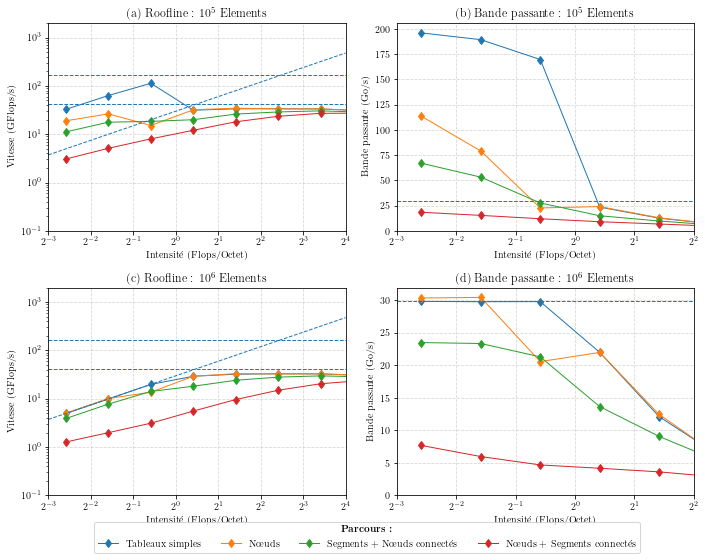

In [9]:
!mkdir fig

plt.figure(figsize=(0.66*textwidth, 2*figheight))

plt.subplot(221).title.set_text("(a) Roofline : $10^5$ Elements")
plot_roofline_perf(8,'1e+05')

plt.subplot(222).title.set_text("(b) Bande passante : $10^5$ Elements")
plot_bandwidth_perf(8,'1e+05')

plt.subplot(223).title.set_text("(c) Roofline : $10^6$ Elements")
plot_roofline_perf(8,'1e+06')

plt.subplot(224).title.set_text("(d) Bande passante : $10^6$ Elements")
plot_bandwidth_perf(8,'1e+06')

plt.tight_layout()
plt.legend(ncol=4, loc='lower center',title="{\\bf Parcours :}", bbox_to_anchor=(-0.1, -0.3))

plt.savefig("fig/bench_mesh_omp_effet_taille.pdf", transparent=True, bbox_inches='tight')
plt.show()


*Figure* - Impact du nombre d'objets contenus dans la structure sur un noeud NUMA (8 threads)

Les figures (a) et (b) montrent les performances pour des données qui tiennent en cache L3. On observe des effects de cache dans la partie * memory-bound * du roofline model.
Les figures (c) et (d) motrent le sperformances lorsque les données ne tienent pas dans le cache L3. On remarque que la performance est limitée par la bande passante RAM dans la partie gauche des graphes.

Dans OptiDis, les données sont souvent évincées du cache car chaque étape de la simulation accède à des champs différents des objets du réseau de dislocations. La mesure la plus pertinante pour connaitre la performance de la structure de données ne doit donc pas prendre en compte les effets de cache. Ce sont les performances pour des tailles de données qui ne tiennent pas en cache qui sont a prendre en compte pour cette étude.

La taille des données n'infuence pas l'efficacité dans la partie compute-bound des graphes.

## Benchmarks MPI

In [10]:
threads=8
intensities=[0,3,9]
list_sizes_mpi = ['1e+05', '1e+06']

nb_procs = np.array(list_nb_procs)

times_max={}
times_min={}
for size in list_sizes_mpi:        
    for name in list_names:
        for intensity in intensities:
            times_max[size,name,intensity] = np.array([ max([ res_matrix[p,rank,threads,size,name][intensity] for rank in range(p) ]) for p in nb_procs ])
            times_min[size,name,intensity] = np.array([ min([ res_matrix[p,rank,threads,size,name][intensity] for rank in range(p) ]) for p in nb_procs ])
intensity_val={}
for intensity in intensities:
    intensity_val[intensity] = flops_count['1e+05',1][intensity]/loadstore_size['1e+05',1][intensity]

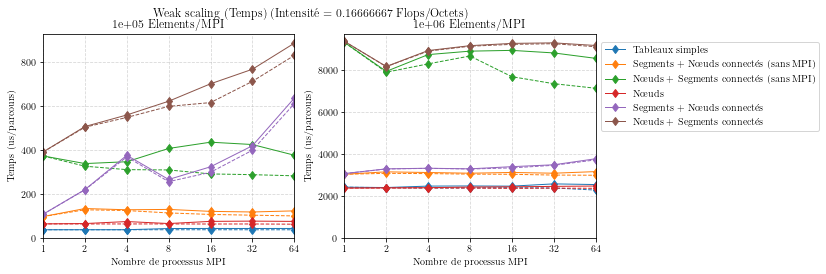

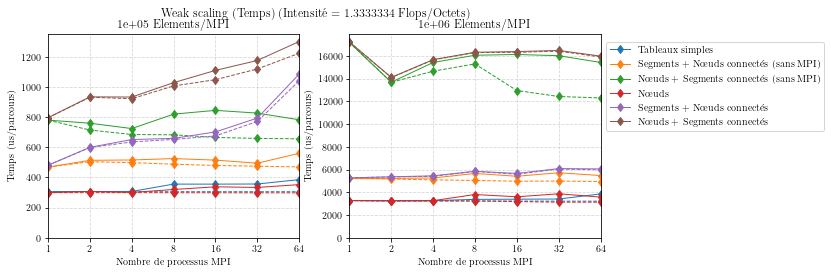

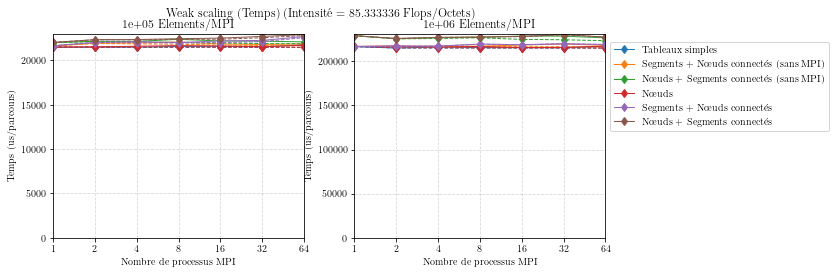

In [11]:
def xaxis_mpi():
    #ax.set_xticks(nb_procs)
    #plt.xscale('log',basex=2)
    plt.xlim([1,64])
    plt.xlabel("Nombre de processus MPI")
    plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

def plot_times_mpi(intensity, size, my_list_names) :
    for name in my_list_names:
        nb_procs = np.array(list_nb_procs)
        line, = plt.plot( nb_procs, times_max[size,name,intensity],'d-', label=label_names[name], linewidth=1 )
        plt.plot( nb_procs, times_min[size,name,intensity],'d--', linewidth=1, color=line.get_color())
    plt.xscale('log',basex=2)
    plt.ylim(0)
    plt.ylabel("Temps (us/parcours)")
    xaxis_mpi()

for intensity in intensities:
    i=1
    fig,ax=plt.subplots()
    plt.suptitle("Weak scaling (Temps) (Intensité = "+str(intensity_val[intensity])+" Flops/Octets)")
    for size in list_sizes_mpi:        
        plt.subplot(1, 2, i).title.set_text(size+" Elements/MPI")
        plot_times_mpi(intensity, size, list_names)             
        i=i+1
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5)) 
    plt.show()

Dans les graphes précédents, la ligne pleine représente le temps maximum, et les pointillés le temps minimum. Des pointillés non-confondus avec la ligne pleine indiquent une différence de charge entre les différents processus.

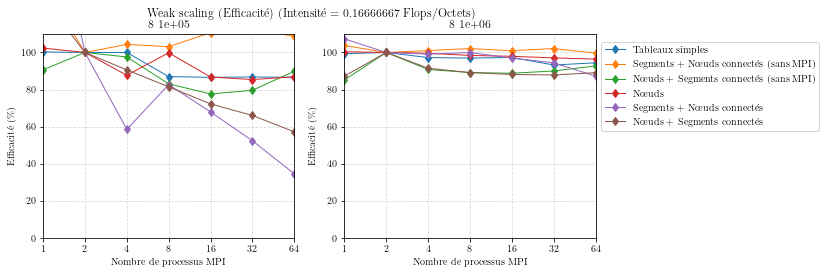

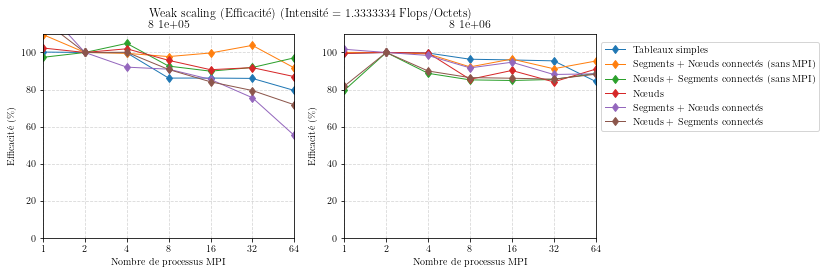

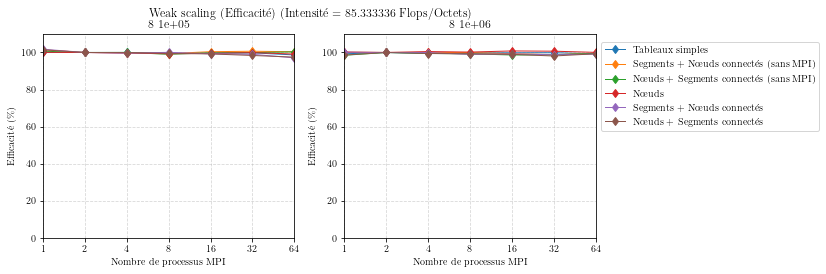

In [12]:
def plot_mpi_efficiency(intensity, size, my_list_names ) :
    for name in my_list_names:
        plt.plot( nb_procs, times_max[size,name,intensity][1]/times_max[size,name,intensity]*100, 'd-', label=label_names[name], linewidth=1 )
    plt.xscale('log',basex=2)
    plt.ylim([0,110])
    plt.ylabel("Efficacité (\%)")
    xaxis_mpi()

for intensity in intensities:
    i=1
    plt.suptitle("Weak scaling (Efficacité) (Intensité = "+str(intensity_val[intensity])+" Flops/Octets)")
    for size in list_sizes_mpi:        
        plt.subplot(1, 2, i).title.set_text(size+" Elements/MPI")
        plot_mpi_efficiency(intensity, size, list_names )
        #plt.ylim([0,110])
        plt.title(str(threads)+" "+size)
        i=i+1
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5)) 
    plt.show()

#### Apercu 

mkdir: cannot create directory ‘fig’: File exists


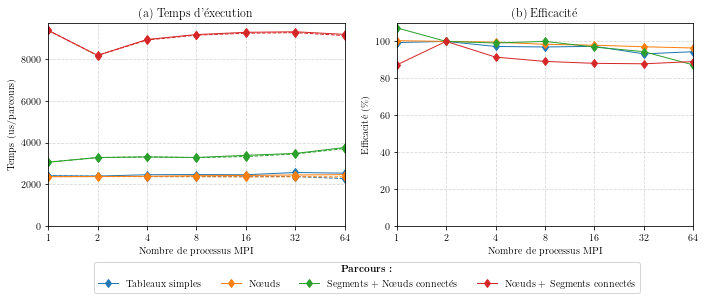

In [13]:
!mkdir fig

intensity=0
my_list_names = ['Stream', 'Nodes', 'Segs with Nodes', 'Nodes with Segs' ]

plot_mpi_efficiency(intensity, '1e+05', my_list_names)
plt.subplot(121).title.set_text("(a) Temps d'éxecution")
plot_times_mpi(intensity, '1e+06', my_list_names)
plt.subplot(122).title.set_text("(b) Efficacité")
plot_mpi_efficiency(intensity, '1e+06', my_list_names)

plt.tight_layout()
plt.legend(ncol=4, loc='upper center',  title="{\\bf Parcours :}", bbox_to_anchor=(-0.1, -0.15))

plt.savefig("fig/bench_mesh_mpi_preview.pdf", transparent=True, bbox_inches='tight')
plt.show()

#### Impact de la taille des données

mkdir: cannot create directory ‘fig’: File exists


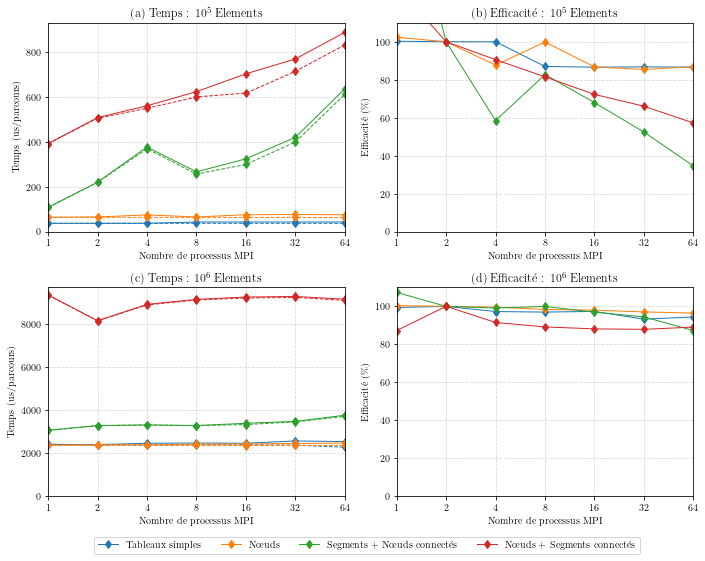

In [14]:
!mkdir fig

intensity=0
my_list_names = ['Stream', 'Nodes', 'Segs with Nodes', 'Nodes with Segs' ]

plt.figure(figsize=(0.66*textwidth, 2*figheight))

plt.subplot(221).title.set_text("(a) Temps : $10^5$ Elements")
plot_times_mpi(intensity, '1e+05', my_list_names)
plt.subplot(222).title.set_text("(b) Efficacité : $10^5$ Elements")
plot_mpi_efficiency(intensity, '1e+05', my_list_names)
plt.subplot(223).title.set_text("(c) Temps : $10^6$ Elements")
plot_times_mpi(intensity, '1e+06', my_list_names)
plt.subplot(224).title.set_text("(d) Efficacité : $10^6$ Elements")
plot_mpi_efficiency(intensity, '1e+06', my_list_names)

plt.tight_layout()
plt.legend(ncol=4, loc='lower center', bbox_to_anchor=(-0.1, -0.3))

plt.savefig("fig/bench_mesh_mpi_effet_taille.pdf", transparent=True, bbox_inches='tight')
plt.show()

 *Figure* - Performance MPI des parcours de la structure de données pour une intensité de 0.17 Flops/Octet sur 1 noeud NUMA (8 threads) par processus MPI

# Benchmark Insertion

In [15]:
!grep -r '# Mesh construct time = ' data/out_* > data/mesh_insert_data.txt

res_matrix_insert={}

for line in open("data/mesh_insert_data.txt"):
    nb_proc,rank,threads,size,t = re.match(".*out_p(\d*)_r(\d*)_t(\d*)_s(\d*e\+\d*):# Mesh construct time = (\d*.\d*) ms", line).groups()
    rank=int(rank)
    nb_proc=int(nb_proc)
    threads=int(threads)
    res_matrix_insert[nb_proc,rank,threads,size] = float(t)

list_nb_procs = np.array(sorted([a for a in set([ p for (p,r,t,s) in  res_matrix_insert.keys() ])]))
list_threads = sorted([a for a in set([ t for (p,r,t,s) in  res_matrix_insert.keys() ])])
list_sizes = sorted([a for a in set([ s for (p,r,t,s) in  res_matrix_insert.keys() ])])

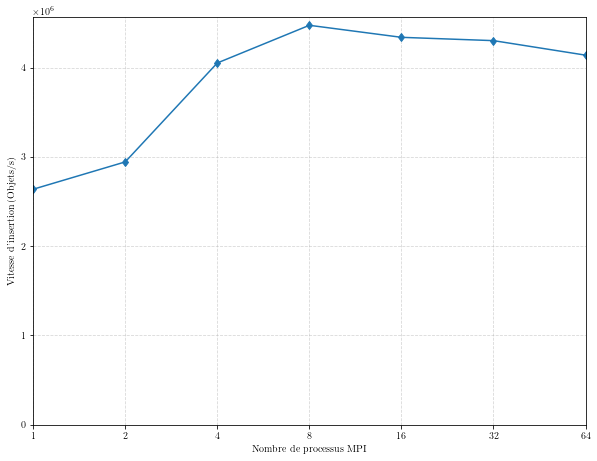

In [16]:
rank=0
threads=8
size='1e+06'

plt.figure(figsize=(0.66*textwidth, 2*figheight))
times = np.array([ res_matrix_insert[nb_proc,rank,threads,size] for nb_proc in list_nb_procs ])
nb_objects = (2*float(size)*list_nb_procs)
plt.plot( list_nb_procs, nb_objects/(times/1000), 'd-' )
plt.ylabel("Vitesse d'insertion (Objets/s)")
plt.xlim([1,64])
plt.ylim(0)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
plt.xscale('log',basex=2)
xaxis_mpi()
plt.show()